# Supervised Learning Review

Algorithms covered:
- Logistic Regression
- KNN
- Decision Trees
- Random Forests
- GBMs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.neighbors import *
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)

In [2]:
def plot_data(X, y, model=None, h=0.01, figsize=(6, 6), s=20, alpha=0.7, edgecolor='black'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    fig, ax = plt.subplots(figsize=figsize)
    
    classes = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    if model is not None:
        yhat = model.predict(grid).reshape(xx.shape)
        ax.contourf(xx, yy, yhat, alpha=0.1, cmap=plt.cm.rainbow)
        plt.axis('tight')
    
    for i, color in zip(classes, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color, label=f'$y={i}$', edgecolor=edgecolor, s=s, alpha=alpha)
    
    plt.axis('tight')
    ax.set(aspect='equal', xlabel='$x_1$', ylabel='$x_2$')
    ax.legend(loc='best')
    plt.show()

In [3]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=2., random_state=seed, shuffle=True)
X.shape, y.shape

((1000, 2), (1000,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

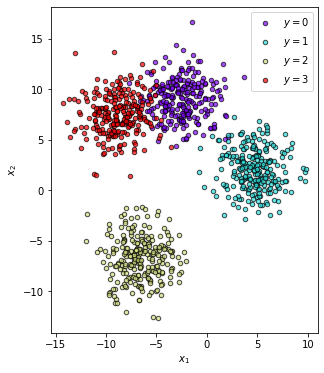

In [5]:
plot_data(X, y)

## Logistic Regression

Easy to describe, surprisingly tricky to actually implement.

In [6]:
class LogisticRegressionModel:
    def __init__(self):
        pass
        
    def fit(self, X, y):
        from scipy import optimize
        def cost_fn(params, X, y):
            num_features, num_targets = X.shape[1], len(set(y))
            params = params.reshape(num_targets, num_features + 1)
            weights = params[:, :-1].reshape(num_targets, num_features)
            bias = params[:, -1].reshape(num_targets, 1)
            yhat = self._activation_fn(weights @ X.T + bias)
            return self._loss_fn(y, yhat)
        
        self.multiclass = len(np.unique(y)) > 2
        self._activation_fn = self._sigmoid if not self.multiclass else self._softmax
        self._loss_fn = self._binary_crossentropy if not self.multiclass else self._crossentropy
        num_features = X.shape[1]
        num_targets = len(np.unique(y)) if self.multiclass else 1

        params = np.zeros((num_targets, num_features + 1))
        opt_res = optimize.minimize(cost_fn, params, method='BFGS', args=(X, y))
        results = opt_res.x.reshape(num_targets, num_features + 1)
        self.weights = results[:, :-1].reshape(num_targets, num_features)
        self.bias = results[:, -1].reshape(num_targets, 1)

    def predict_proba(self, X):
        return self._activation_fn(self.weights @ X.T + self.bias)
            
    def predict(self, X):
        if not self.multiclass:
            y_pred = self.predict_proba(X).round()
        else:
            y_pred = self.predict_proba(X).T.argmax(axis=-1)
        return y_pred.T
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    @staticmethod
    def _sigmoid(z):
        return 1 / (1 + np.exp(-z))
        
    @staticmethod
    def _softmax(z):
        exps = np.exp(z - z.max())
        return exps / np.sum(exps)
    
    @staticmethod
    def _binary_crossentropy(y, yhat, eps=1e-9):
        yhat = np.clip(yhat, eps, 1 - eps)
        loss = -np.mean(y * np.log(yhat + eps) + (1 - y) * np.log(1 - yhat + eps))
        return loss.item()

    @staticmethod
    def _crossentropy(y, yhat, eps=1e-9):
        yhat = np.clip(yhat, eps, 1-eps)
        loss = -np.mean(np.log(yhat[y, np.arange(len(y))]))
        return loss.item()

In [7]:
model = LogisticRegressionModel()
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9714285714285714, 0.97)

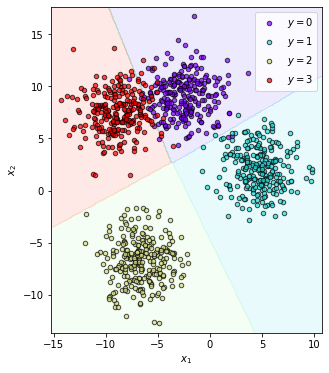

In [8]:
plot_data(X, y, model=model, h=0.1)

In [9]:
%%timeit

model = LogisticRegressionModel()
model.fit(X_train, y_train)
model.score(X_test, y_test)

34.3 ms ± 582 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%%timeit

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

6.73 ms ± 36.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## k-Nearest Neighbors (KNN)

Easy to describe, and easy to implement.

In [11]:
def knn(X, y, k):
    def nearest_neighbors(X, k):
        norm = lambda x1, x2: np.sum((x1 - x2)**2)
        distances = np.array([[norm(x1, x2) for j, x2 in enumerate(X)] for i, x1 in enumerate(X)])
        # create (n,k) array neighbors where neighbors[i] = [nbr_idx_i1, ..., nbr_idx_ik]
        neighbors = np.argpartition(distances, k, axis=-1)[:, :k]
        return neighbors
    neighbors = nearest_neighbors(X, k)
    y_pred = np.array([np.median([y[idx] for idx in row]).round().astype(int) for row in neighbors])
    return y_pred

y_pred = knn(X_train, y_train, 2)
accuracy_score(y_train, y_pred)

0.9557142857142857

In [12]:
class KNNModel:
    def __init__(self, k=1, metric='euclidean', classification=True):
        self.k = k
        self.metric = metric
        self.classification = classification
        
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, x):
        x = np.array(x)
        x = x if len(x.shape) > 1 else x[None, :]
        distances = self._get_distances(self.X, x=x)
        neighbors = self._get_neighbors(distances.T)
        y_pred = np.array([self._majority_vote(example) for example in neighbors])
        return y_pred
    
    def score(self, x, y):
        y_pred = self.predict(x)
        if self.classification:
            score = accuracy_score(y, y_pred)
        else:
            score = mean_squared_error(y, y_pred)
        return score
    
    def _dist(self, x1, x2):
        if self.metric == 'euclidean':
            dist = np.sum((x1 - x2)**2)
        elif self.metric == 'cosine':
            dist = np.dot(x1 - x2, x1 - x2) / np.sqrt(np.dot(x1, x1) * np.dot(x2, x2))
        return dist
    
    def _get_distances(self, X, x=None):
        if x is not None:
            distances = np.array([[self._dist(x1, x2) for j, x2 in enumerate(x)] for i, x1 in enumerate(self.X)])
        else:
            distances = np.array([[self._dist(x1, x2) for j, x2 in enumerate(self.X)] for i, x1 in enumerate(self.X)])
        return distances
    
    def _get_neighbors(self, distances):
        return np.argpartition(distances, self.k, axis=-1)[:, :self.k]
    
    def _majority_vote(self, row):
        if self.classification:
            vote = np.median([self.y[idx] for idx in row]).round().astype(int)
        else:
            vote = np.mean([self.y[idx] for idx in row])
        return vote

In [13]:
model = KNNModel(k=5)
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9785714285714285, 0.9733333333333334)

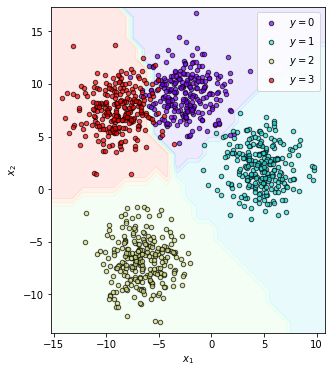

In [14]:
plot_data(X, y, model=model, h=1)

In [15]:
%%timeit

model = KNNModel(k=5)
model.fit(X_train, y_train)
model.score(X_test, y_test)

436 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
model.score(X_test, y_test)

2.46 ms ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Decision Trees

In [17]:
class DecisionTreeNode:
    def __init__(self, depth, split_feature=None, split_value=None, label=None, gain=None, features=None,
                 left=None, right=None):
        self.depth = depth
        self.split_feature = split_feature
        self.split_value = split_value
        self.label = label
        self.gain = gain
        self.features = list(features) if features is not None else None
        self.state_dict = {k:v for k, v in self.__dict__.items() if v is not None}
        self.left = left
        self.right = right
        
    def __repr__(self):
        return f'DecisionTreeNode({self.state_dict}, left={self.left}, right={self.right})'
    
    def print_tree(self, level=0):
        state_dict = {k:(round(v, 5) if isinstance(v, float) else v) for k, v in self.state_dict.items()}
        indent = '    '
        if self is not None:
            current_level = level
            print(f'{indent * current_level} {state_dict}')
            if self.left is not None:
                self.left.print_tree(current_level + 1)
            if self.right is not None:
                self.right.print_tree(current_level + 1)

def build_decision_tree(X, y, max_depth=10, min_samples_leaf=2, max_features=None):
    def recurse(X, y, depth, idxs, max_depth=max_depth):
        if depth == max_depth or len(idxs) <= min_samples_leaf:
            label = np.median([y[idx] for idx in idxs]).astype(int).item() if len(idxs) > 0 else -1
            node = DecisionTreeNode(depth, label=label)
        else:
            features = split_features(X.shape[1], max_features)
            split_feature, split_value, info_gain = get_best_split(X, y, idxs, features)
            node = DecisionTreeNode(depth, split_feature=split_feature, split_value=split_value, gain=info_gain,
                                    features=features)
            idxs_left, idxs_right = split_dataset(X, idxs, split_feature, split_value)
            node.left = recurse(X, y, depth + 1, idxs_left)
            node.right = recurse(X, y, depth + 1, idxs_right)
        return node
    return recurse(X, y, 0, np.arange(len(y)))

def decision_tree_predict(X, tree):
    y_pred = np.zeros((len(X)))
    def recurse(X, node, depth=0, idxs=None):
        if node.left is None:
            y_pred[idxs] = node.label
        else:
            idxs_left, idxs_right = split_dataset(X, idxs, node.split_feature, node.split_value)
            recurse(X, node.left, depth + 1, idxs_left)
            recurse(X, node.right, depth + 1, idxs_right)
    recurse(X, tree, idxs=np.arange(len(X)))
    return y_pred

def split_dataset(X, idxs, split_feature, split_value):
    left_indices = [idx for idx in idxs if X[idx, split_feature] < split_value]
    right_indices = [idx for idx in idxs if X[idx, split_feature] >= split_value]  
    return left_indices, right_indices

def split_features(num_features, max_features):
    if max_features is None:
        return range(num_features)
    else:
        return np.random.choice(range(num_features), size=int(max_features * num_features), replace=False)

def get_entropy(y):
    from scipy.stats import entropy
    _, counts = np.unique(y, return_counts=True)
    return entropy(counts, base=2)

def get_info_gain(X, y, idxs, split_feature, split_value):
    idxs_left, idxs_right = split_dataset(X, idxs, split_feature, split_value)
    top_entropy = get_entropy(y[idxs])
    right_entropy, left_entropy = get_entropy(y[idxs_right]), get_entropy(y[idxs_left])
    w_right = len(y[idxs_right]) / len(y[idxs]) if len(y[idxs]) > 0 else 0
    w_left = len(y[idxs_left]) / len(y[idxs]) if len(y[idxs]) > 0 else 0
    info_gain = top_entropy - (w_left * left_entropy + w_right * right_entropy)
    return info_gain

def get_best_split(X, y, idxs, features):
    num_features = X.shape[1]
    best_info_gain, split_feature, split_value = -np.inf, -1, np.inf
    for feature in features:
        sample_values = np.random.choice(X[:, feature], size=100, replace=False) if len(X) > 100 else X[:, feature]
        for i, value in enumerate(X[:, feature]):
            info_gain = get_info_gain(X, y, idxs, feature, value)
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                split_feature = feature
                split_value = value
    return split_feature, split_value, best_info_gain

In [18]:
X_tmp = np.array([[1,1,1],[1,0,1],[1,0,0],[1,0,0],[1,1,1],[0,1,1],[0,0,0],[1,0,1],[0,1,0],[1,0,0]])
y_tmp = np.array([1,1,0,0,1,0,0,1,1,0])
X_tmp.shape, y_tmp.shape

((10, 3), (10,))

In [19]:
tree = build_decision_tree(X_tmp, y_tmp, max_depth=2)
tree.print_tree()

 {'depth': 0, 'split_feature': 2, 'split_value': 1, 'gain': 0.27807, 'features': [0, 1, 2]}
     {'depth': 1, 'split_feature': 1, 'split_value': 1, 'gain': 0.72193, 'features': [0, 1, 2]}
         {'depth': 2, 'label': 0}
         {'depth': 2, 'label': 1}
     {'depth': 1, 'split_feature': 0, 'split_value': 1, 'gain': 0.72193, 'features': [0, 1, 2]}
         {'depth': 2, 'label': 0}
         {'depth': 2, 'label': 1}


In [20]:
y_pred = decision_tree_predict(X_tmp, tree)
accuracy_score(y_tmp, y_pred)

1.0

In [21]:
class DecisionTreeModel:
    def __init__(self, max_depth=10, min_samples_leaf=2, criterion='entropy', max_features=None):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_features = max_features
        
    def fit(self, X, y):
        self._build_decision_tree(X, y)
        
    def predict(self, X):
        return self._decision_tree_predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def _build_decision_tree(self, X, y):
        def recurse(self, X, y, depth, idxs):
            if depth == self.max_depth or len(idxs) <= self.min_samples_leaf:
                label = np.median([y[idx] for idx in idxs]).astype(int).item() if len(idxs) > 0 else np.nan
                node = DecisionTreeNode(depth, label=label)
            else:
                features = self._split_features(X.shape[1])
                split_feature, split_value, info_gain = self._get_best_split(X, y, idxs, features)
                node = DecisionTreeNode(depth, split_feature=split_feature, split_value=split_value, gain=info_gain,
                                        features=features)
                idxs_left, idxs_right = self._split_dataset(X, idxs, split_feature, split_value)
                node.left = recurse(self, X, y, depth + 1, idxs_left)
                node.right = recurse(self, X, y, depth + 1, idxs_right)
            return node
        self.tree = recurse(self, X, y, 0, np.arange(len(y)))

    def _decision_tree_predict(self, X):
        y_pred = np.zeros((len(X)))
        def recurse(X, node, depth=0, idxs=None):
            if node.left is None or node.right is None:
                y_pred[idxs] = node.label
            else:
                idxs_left, idxs_right = self._split_dataset(X, idxs, node.split_feature, node.split_value)
                recurse(X, node.left, depth + 1, idxs_left)
                recurse(X, node.right, depth + 1, idxs_right)
        recurse(X, self.tree, idxs=np.arange(len(X)))
        return y_pred
    
    @staticmethod
    def _split_dataset(X, idxs, split_feature, split_value):
        left_indices = [idx for idx in idxs if X[idx, split_feature] < split_value]
        right_indices = [idx for idx in idxs if X[idx, split_feature] >= split_value]  
        return left_indices, right_indices
    
    def _split_features(self, num_features):
        if self.max_features is None:
            return range(num_features)
        elif self.max_features == 'sqrt':
            max_features = np.sqrt(num_features).round().astype(int)
            return np.random.choice(range(num_features), size=max_features, replace=False)
        else:
            return np.random.choice(range(num_features), size=int(self.max_features * num_features), replace=False)

    @staticmethod
    def _entropy(y):
        from scipy.stats import entropy
        _, counts = np.unique(y, return_counts=True)
        return entropy(counts, base=2)
    
    @staticmethod
    def _gini(y):
        _, counts = np.unique(y, return_counts=True)
        return 1 - np.sum((counts / len(y))**2)
    
    def _impurity_fn(self, y):
        return self._gini(y) if self.criterion == 'gini' else self._entropy(y)

    def _get_info_gain(self, X, y, idxs, split_feature, split_value):
        idxs_left, idxs_right = self._split_dataset(X, idxs, split_feature, split_value)
        top_impurity = self._impurity_fn(y[idxs])
        right_impurity, left_impurity = self._impurity_fn(y[idxs_right]), self._impurity_fn(y[idxs_left])
        w_right = len(idxs_right) / len(idxs) if len(idxs) > 0 else 0
        w_left = len(idxs_left) / len(idxs) if len(idxs) > 0 else 0
        info_gain = top_impurity - (w_left * left_impurity + w_right * right_impurity)
        return info_gain

    def _get_best_split(self, X, y, idxs, features):
        num_features = X.shape[1]
        best_info_gain, split_feature, split_value = -np.inf, -1, np.inf
        for feature in features:
            sample_values = np.random.choice(X[:, feature], size=30, replace=False) if len(X) > 30 else X[:, feature]
            for i, value in enumerate(sample_values):
                info_gain = self._get_info_gain(X, y, idxs, feature, value)
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    split_feature = feature
                    split_value = value
        return split_feature, split_value, best_info_gain
    
    def print_tree(self):
        self.tree.print_tree()

In [22]:
model = DecisionTreeModel(max_depth=3, min_samples_leaf=2, criterion='gini')
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9485714285714286, 0.9633333333333334)

In [23]:
model.tree.print_tree()

 {'depth': 0, 'split_feature': 1, 'split_value': -2.59557, 'gain': 0.22556, 'features': [0, 1]}
     {'depth': 1, 'split_feature': 0, 'split_value': 1.95098, 'gain': 0.01227, 'features': [0, 1]}
         {'depth': 2, 'split_feature': 0, 'split_value': -7.02283, 'gain': 0.0, 'features': [0, 1]}
             {'depth': 3, 'label': 2}
             {'depth': 3, 'label': 2}
         {'depth': 2, 'label': 1}
     {'depth': 1, 'split_feature': 0, 'split_value': 0.02462, 'gain': 0.27136, 'features': [0, 1]}
         {'depth': 2, 'split_feature': 0, 'split_value': -6.11576, 'gain': 0.38262, 'features': [0, 1]}
             {'depth': 3, 'label': 3}
             {'depth': 3, 'label': 0}
         {'depth': 2, 'split_feature': 1, 'split_value': 5.63703, 'gain': 0.12418, 'features': [0, 1]}
             {'depth': 3, 'label': 1}
             {'depth': 3, 'label': 0}


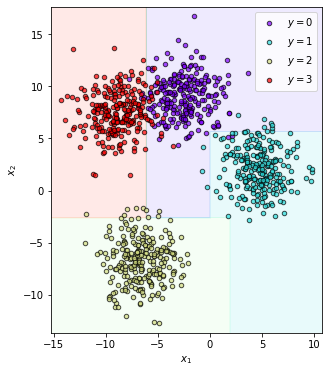

In [24]:
plot_data(X, y, model=model, h=0.1)

In [25]:
%%timeit

model = DecisionTreeModel(max_depth=3, min_samples_leaf=2)
model.fit(X_train, y_train)
model.score(X_test, y_test)

48.8 ms ± 58.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%%timeit

model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)
model.fit(X_train, y_train)
model.score(X_test, y_test)

366 µs ± 4.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Random Forests

- For $b=1,\cdots,B$:
    - Randomly sample $N$ times from $X, y$ with replacement to get training data $X_b, y_b$ to use.
    - Build a decision tree $T_b$ using $X_b, y_b$.
    - At each node in $T_b$, randomly sample a subset $f$ of features to split on. Typically, $|f| \sim \sqrt{|F|}$.
- Given a bag of trees $T_1,\cdots,T_B$, make predictions by taking a majority vote across all trees:
$$\hat y = \text{mode}(\hat y_1, \cdots, \hat y_B).$$

https://mljar.com/blog/feature-importance-in-random-forest/

In [27]:
class RandomForestModel:
    def __init__(self, n_estimators=10, max_depth=10, min_samples_leaf=2, criterion='entropy', max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_features = max_features
        self.trees = []
        
    def fit(self, X, y):
        self.num_features = X.shape[1]
        self.num_targets = len(np.unique(y))
        for b in range(self.n_estimators):
            Xb, yb = self._sample_data(X, y)
            tree = DecisionTreeModel(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, 
                                     criterion=self.criterion, max_features=self.max_features)
            tree.fit(Xb, yb)
            self.trees.append(tree)
        
    def predict_proba(self, X):
        from collections import Counter
        y_preds = np.zeros((len(X), self.n_estimators))
        for b in range(self.n_estimators):
            tree = self.trees[b]
            y_preds[:, b] = tree.predict(X)
        y_counts = np.array([[Counter(row)[x] for x in range(self.num_targets)] for row in y_preds])
        y_probs = y_counts / y_counts.sum(axis=1).reshape(-1, 1)
        return y_probs
    
    def predict(self, X):
        y_preds = np.zeros((len(X), self.n_estimators))
        for b in range(self.n_estimators):
            tree = self.trees[b]
            y_preds[:, b] = tree.predict(X)
        y_pred = np.median(y_preds, axis=1).round().astype(int)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    @staticmethod
    def _sample_data(X, y):
        idxs = np.random.choice(len(y), replace=True, size=len(y))
        return X[idxs], y[idxs]
    
    def get_feature_importances(self):
        # walk down each tree, calculating how much each split feature maximizes gain
        feature_dict = {feature: [] for feature in range(self.num_features)}
        def recurse(node):
            if node is not None and node.split_feature is not None:
                feature_dict[node.split_feature].append(node.gain)
                recurse(node.left)
                recurse(node.right)
        for b in range(self.n_estimators):
            tree = self.trees[b].tree
            recurse(tree)            
        # average decreases for each feature across all trees and return
        feature_importances = [np.mean(feature_dict[feature]) for feature in range(len(feature_dict))]
        return np.array(feature_importances) / sum(feature_importances)
    
    def plot_feature_importances(self, feature_names=None, sort=True, **kwargs):
        feature_importances = self.get_feature_importances()
        feature_names = np.range(len(feature_importances)) if feature_names is None else np.array(feature_names)
        idxs = feature_importances.argsort() if sort else range(len(feature_importances))
        plt.barh(feature_names[idxs], feature_importances[idxs], **kwargs)
        plt.title('Feature Importances')
        plt.show()

In [28]:
model = RandomForestModel(n_estimators=30, max_depth=3, min_samples_leaf=2, criterion='gini', max_features='sqrt')
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.97, 0.9766666666666667)

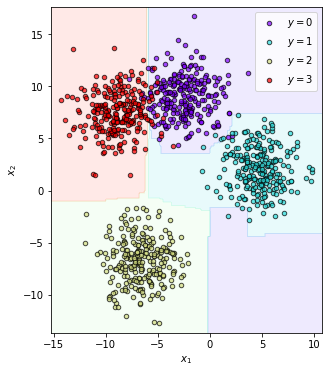

In [29]:
plot_data(X, y, model=model, h=0.1)

In [30]:
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)
y_pred.shape, y_probs.shape

((300,), (300, 4))

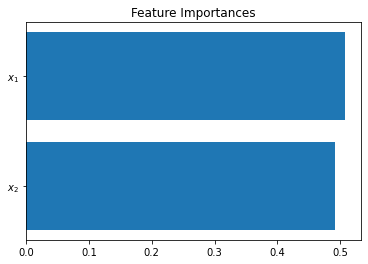

In [31]:
model.plot_feature_importances(feature_names=[r'$x_1$', r'$x_2$'])

In [32]:
%%timeit

model = RandomForestModel(n_estimators=30, max_depth=3, criterion='gini', max_features='sqrt')
model.fit(X_train, y_train)
model.score(X_test, y_test)

717 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit

model = RandomForestClassifier(n_estimators=30, max_depth=3, criterion='gini', max_features='sqrt')
model.fit(X_train, y_train)
model.score(X_test, y_test)

15 ms ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Gradient Boosting Machines (GBMs)

- Specify a "learning rate" $0 \leq \gamma \leq 1$. Typical values are 0.1-0.3.
- Note: The trees $T_b$ are called **weak learners** since they fit residuals rather than the full output.
- For classification: One-hot encode the targets $y$ to get an $N\times K$ array $Y$.
- Initialize predictions to be the target means: $\hat Y_0 = \text{mean}_{k=1,\cdots,K} Y$.
- For $b=1,\cdots,B$ in sequence:
    - Optional: Randomly sample $N$ times from $X, Y$ with replacement to get training data $X_b, Y_b$ to use.
    - Build a *regression* decision tree $T_b$ using $X_b$ to predict the residuals $r_b$ defined by
        - Regression: $r_b \equiv Y_b - \hat Y_{b-1},$
        - Binary Classification: $r_b \equiv Y_b - \text{sigmoid}\big(\hat Y_{b-1}\big),$
        - Multiclass Classification: $r_b \equiv Y_b - \text{softmax}\big(\hat Y_{b-1}\big).$
    - The predictions of each $T_b$ will be $\hat Y_b = \hat Y_0 + \gamma(\hat r_1 + \cdots \hat r_b).$
- Given the sequence of weak learners $T_0,\cdots,T_{B}$, make predictions by taking a sum of all the predicted residuals:
$$y_{pred} = \text{argmax}_{k=1,\cdots,K} \big[ \hat Y_0 + \gamma(\hat r_1 + \cdots \hat r_{B}) \big].$$

https://blog.mattbowers.dev/gradient-boosting-machine-from-scratch

In [34]:
class GradientBoostingModel:
    def __init__(self, n_estimators=100, max_depth=3, min_samples_leaf=2, max_features=None, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.learning_rate = learning_rate
        self.trees = []
        
    def fit(self, X, y):
        self.num_features = X.shape[1]
        self.num_targets = len(np.unique(y))
        Y = self._one_hot(y)
        self.target_means = Y.mean(axis=0)
        Yhat = np.full(Y.shape, self.target_means)
        for b in range(self.n_estimators):
            # evidently sklearn fits one tree per one-hot class for GBMs, so will need to do that to match it
            # note this is a *regression* tree, not a classification tree, due to the residuals being floats
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, 
                                         max_features=self.max_features)
            residuals = self._residuals(Y, Yhat)
            idxs = self._sample_data(X, Y)
            tree.fit(X[idxs, :], residuals[idxs, :])
            Yhat += self.learning_rate * tree.predict(X)
            self.trees.append(tree)
    
    def predict(self, X):
        return self.staged_predict(X)[-1]
    
    def staged_predict(self, X):
        preds = []
        Yhat = np.full((len(X), self.num_targets), self.target_means)
        for b in range(self.n_estimators):
            tree = self.trees[b]
            Yhat += self.learning_rate * tree.predict(X)
            y_pred = Yhat.argmax(axis=1).astype(int)
            preds.append(y_pred)
        return preds

    def predict_proba(self, X):
        return self.staged_predict_proba(X)[-1]
    
    def staged_predict_proba(self, X):
        probs = []
        Yhat = np.full((len(X), self.num_targets), self.target_means)
        for b in range(self.n_estimators):
            tree = self.trees[b]
            Yhat += self.learning_rate * tree.predict(X)
            exps = np.exp(Yhat - Yhat.max())
            Y_prob = exps / np.sum(exps, axis=1)[:, None]
            probs.append(Y_prob)
        return probs
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    @staticmethod
    def _sample_data(X, y):
        idxs = np.random.choice(len(y), replace=True, size=len(y))
        return idxs
    
    def _one_hot(self, y):
        Y = np.zeros((len(y), self.num_targets))
        Y[np.arange(len(y)), y] = 1
        return Y
    
    def _residuals(self, Y, Yhat):
        # residuals = [Y[:, k] - np.exp(Yhat[:, k] - logsumexp(Yhat, axis=1)) for k in range(self.num_targets)]
        # return np.vstack(residuals).T
        exps = np.exp(Yhat - Yhat.max())
        return Y - exps / np.sum(exps, axis=1)[:, None]

In [35]:
model = GradientBoostingModel(n_estimators=30, max_depth=3, min_samples_leaf=2, learning_rate=0.1)
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9714285714285714, 0.9633333333333334)

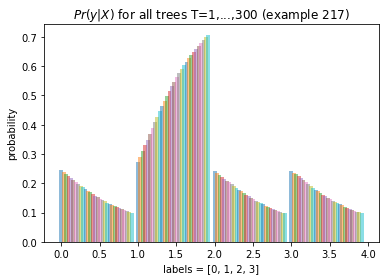

In [36]:
def plot_staged_probs(X, model, idx=None):
    stages = list(model.staged_predict_proba(X))
    xx = np.arange(len(stages[0][0])).astype(float)
    eps = 0.95 * 1 / len(stages)
    idx = np.random.choice(len(X)) if idx is None else idx
    for stages in stages:
        plt.bar(xx, stages[idx], alpha=0.5, width=0.05)
        plt.title(f'$Pr(y|X)$ for all trees T=1,...,{len(stages)} (example {idx})')
        plt.xlabel(f'labels = {np.arange(len(stages[idx])).tolist()}')
        plt.ylabel('probability')
        xx += eps
    plt.show()
    
plot_staged_probs(X_test, model)

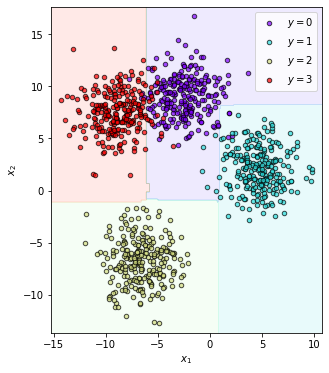

In [37]:
plot_data(X, y, model=model, h=0.1)

In [38]:
%%timeit

model = GradientBoostingModel(n_estimators=30, max_depth=3, min_samples_leaf=2, max_features=None, learning_rate=0.1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

12.6 ms ± 44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
%%timeit

model = GradientBoostingClassifier(n_estimators=30, max_depth=3, min_samples_leaf=2, max_features=None, 
                                   learning_rate=0.1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

51.9 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
